# Counterfactuals

## Structural Causal Model (SCM)

### Structure

In [1]:
import networkx as nx

g = nx.DiGraph()
g.add_nodes_from(['X', 'Z', 'Y'])
g.add_edges_from([('X', 'Z'), ('X', 'Y'), ('Z', 'Y')])

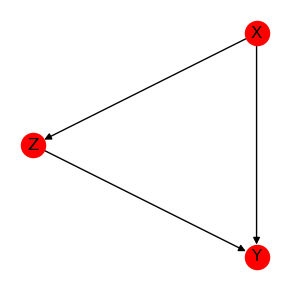

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))

pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
nx.draw(g, pos=pos, with_labels=True, node_color='red')

fig.tight_layout()

### Parameters

- $X \sim \mathcal{N}(1, 1)$
- $Z \sim \mathcal{N}(0.5 X, 1)$
- $Y \sim \mathcal{N}(0.7 X + 0.4 Z, 1)$

In [3]:
import numpy as np
import pandas as pd

np.random.seed(37)

Xy = pd.DataFrame({'X': np.random.normal(1, 1, 10_000)}) \
    .assign(Z=lambda d: np.random.normal(0.5 * d['X'], 1)) \
    .assign(Y=lambda d: np.random.normal(0.7 * d['X'] + 0.4 * d['Z'], 1))
Xy.shape

(10000, 3)

## Linear counterfactual estimation

- $X = e_X$
- $Z = \beta X + e_Z$
- $Y = \alpha X + \gamma Z + e_Y$

In [4]:
from sklearn.linear_model import LinearRegression

X, y = Xy[['X']], Xy['Z']
m_z = LinearRegression(fit_intercept=False).fit(X, y)

pd.Series(m_z.coef_, X.columns)

X    0.499326
dtype: float64

In [5]:
X, y = Xy[['X', 'Z']], Xy['Y']
m_y = LinearRegression(fit_intercept=False).fit(X, y)

pd.Series(m_y.coef_, X.columns)

X    0.704584
Z    0.406117
dtype: float64

### Abduction

In [6]:
x_u = 0.5
z_u = 1.0
y_u = 1.5

In [7]:
e_x = x_u
e_z = (z_u - m_z.predict(pd.DataFrame([[x_u]], columns=['X'])))[0]
e_y = (y_u - m_y.predict(pd.DataFrame([[x_u, z_u]], columns=['X', 'Z'])))[0]

e_x, e_z, e_y

(0.5, 0.7503369785092123, 0.7415910542801099)

## Intervention

In [8]:
z = 2.0

### Prediction

In [9]:
m_y.predict(pd.DataFrame([[x_u, z]], columns=['X', 'Z']))[0] + e_y

1.9061169903480661

## Non-linear counterfactual estimation

In [10]:
from sklearn.ensemble import RandomForestRegressor

X, y = Xy[['X']], Xy['Z']
m_z = RandomForestRegressor(random_state=37, n_jobs=-1).fit(X, y)

X, y = Xy[['X', 'Z']], Xy['Y']
m_y = RandomForestRegressor(random_state=37, n_jobs=-1).fit(X, y)

Abduction

In [11]:
x_u = 0.5
z_u = 1.0
y_u = 1.5

In [12]:
e_x = x_u
e_z = (z_u - m_z.predict(pd.DataFrame([[x_u]], columns=['X'])))[0]
e_y = (y_u - m_y.predict(pd.DataFrame([[x_u, z_u]], columns=['X', 'Z'])))[0]

e_x, e_z, e_y

(0.5, 1.242769153204119, 1.4091147922985516)

Intervention

In [13]:
z = 2.0

Prediction

In [14]:
m_y.predict(pd.DataFrame([[x_u, z]], columns=['X', 'Z']))[0] + e_y

2.2044840873996496

## Discretization

In [15]:
from sklearn.mixture import GaussianMixture

def l2m(means):
    return {i: m for i, m in enumerate(np.ravel(means))}

def m2o(means):
    return {m: i for i, m in enumerate(sorted(np.ravel(means)))}

def l2o(means):
    _l2m = l2m(means)
    _m2o = m2o(means)
    return {l: _m2o[m] for l, m in _l2m.items()}

def discretize(X, n_components=3):
    m = GaussianMixture(n_components=n_components, random_state=37)
    m.fit(X)

    lab2ord = l2o(m.means_)
    s = pd.Series(m.predict(X)) \
        .map(lab2ord) \
        .map({0: 'low', 1: 'med', 2: 'high'})
    return s

df = pd.DataFrame({
    'X': discretize(Xy[['X']]),
    'Y': discretize(Xy[['Y']]),
    'Z': discretize(Xy[['Z']])
})
Xy.shape, df.shape

((10000, 3), (10000, 3))

## Bayesian network

In [16]:
import itertools
from pybbn.pptc import create_pptc_model

data = [('low', 'med', 'high') for _ in ['X', 'Z']]
data = itertools.product(*data)
data = ([x, z, df[(df['X']==x) & (df['Z']==z)].shape[0] / df[df['X']==x].shape[0]] for x, z in data)
z_param = list(data)

data = [('low', 'med', 'high') for _ in ['X', 'Z', 'Y']]
data = itertools.product(*data)
data = ([x, z, y, df[(df['X']==x) & (df['Z']==z) & (df['Y']==y)].shape[0] / df[(df['X']==x) & (df['Z']==z)].shape[0]] for x, z, y in data)
y_param = list(data)

p = {
    'X': {
        'columns': ['X', '__p__'],
        'data': [
            ['low', df[df['X']=='low'].shape[0] / df.shape[0]],
            ['med', df[df['X']=='med'].shape[0] / df.shape[0]],
            ['high', df[df['X']=='high'].shape[0] / df.shape[0]]
        ]
    },
    'Z': {
        'columns': ['X', 'Z', '__p__'],
        'data': z_param
    },
    'Y': {
        'columns': ['X', 'Z', 'Y', '__p__'],
        'data': y_param
    }
}

m = create_pptc_model(g, p)

In [17]:
q = m.query()

In [18]:
q['X']

,X,__p__
0,high,0.2635
1,low,0.2270
2,med,0.5095


In [19]:
q['Z']

,Z,__p__
0,high,0.2385
1,low,0.2673
2,med,0.4942


In [20]:
q['Y']

,Y,__p__
0,high,0.2796
1,low,0.2354
2,med,0.4850


Abduction

In [21]:
x_u = 'med'
z_u = 'low'
y_u = 'med'

In [22]:
e_x = m.query(['X'])['X'].set_index(['X']).loc[x_u].__p__

_e = m.get_observation_evidences({'X': x_u})
e_z = m.query(['Z'], evidences=_e)['Z'].set_index(['Z']).loc[z_u].__p__

_e = m.get_observation_evidences({'X': x_u, 'Z': z_u})
e_y = m.query(['Y'], evidences=_e)['Y'].set_index(['Y']).loc[y_u].__p__

e_x, e_z, e_y

(0.5095, 0.26123650637880275, 0.5514650638617581)

Action

In [23]:
z = 'high'

Prediction

In [24]:
_e = m.get_observation_evidences({'X': x_u, 'Z': z})

m.query(['Y'], evidences=_e)['Y'].set_index(['Y']).loc['high'].__p__ + e_y

0.9810946934913878

## Random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

Xy_df = df.assign(
    X=lambda d: d['X'].map({'low': 0, 'med': 1, 'high': 2}),
    Y=lambda d: d['Y'].map({'low': 0, 'med': 1, 'high': 2}),
    Z=lambda d: d['Z'].map({'low': 0, 'med': 1, 'high': 2})
)

X, y = Xy_df[['X']], Xy_df['Z']
m_z = RandomForestClassifier(random_state=37).fit(X, y)

X, y = Xy_df[['X', 'Z']], Xy_df['Y']
m_y = RandomForestClassifier(random_state=37).fit(X, y)

Abduction

In [31]:
x_u = 1
z_u = 0
y_u = 1

In [32]:
e_x = x_u
e_z = z_u - m_z.predict_proba(pd.DataFrame([[x_u]], columns=['X']))[0,z_u]
e_y = y_u - m_y.predict_proba(pd.DataFrame([[x_u, z_u]], columns=['X', 'Z']))[0, y_u]

e_x, e_z, e_y

(1, -0.26134255453494204, 0.4485814895278367)

Action

In [33]:
z = 2

Prediction

In [35]:
m_y.predict_proba(pd.DataFrame([[x_u, z]], columns=['X', 'Z']))[:,1] + e_y

array([0.95920565])